## Introduction

Propaganda detection is a critical task in natural language processing (NLP) with implications for various domains such as news media analysis, social media monitoring, and misinformation detection. In this project, we aim to detect propaganda in sentences and identify the type of propaganda present, if any. We employ several machine learning and deep learning techniques to tackle these tasks, including Word2Vec with SVM, BERT sequence classification, and TF-IDF with SVM.

### Tasks Overview:
1. **Propaganda Detection Task**: This task involves determining whether a given sentence contains propaganda or not. 
   
2. **Propaganda Type Detection Task**: In addition to detecting the presence of propaganda, we aim to identify the specific type of propaganda exhibited in a sentence. Common types of propaganda include bandwagon, fear, glittering generalities, and more.

### Methods:
- **TF-IDF with SVM**: We start with a traditional approach using TF-IDF (Term Frequency-Inverse Document Frequency) for feature extraction, followed by training a Support Vector Machine (SVM) classifier.
  
- **Word2Vec with SVM**: Word embeddings capture semantic relationships between words, instead of static word counts in TF-IDF that don't add any semantic information. We utilize Word2Vec embeddings to represent sentences and train an SVM classifier on these representations.
  
- **BERT Sequence Classification**: BERT (Bidirectional Encoder Representations from Transformers) has demonstrated state-of-the-art performance in various NLP tasks. We fine-tune a pre-trained BERT model for sequence classification to detect propaganda and its types.



In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import torch
import re

# Natural Language Processing tools
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
# spacy.cli.download("en_core_web_md")

# Machine Learning tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning and Transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


c:\Users\ao507\OneDrive - University of Sussex\Documents\propaganda-detection-3\pdenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ao507\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ao507\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ao507\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading and Cleaning

- Loaded training and validation datasets containing sentences labeled for propaganda detection.
- Checked for null values in both datasets; no null values were found.
- Removed duplicates from both datasets to ensure data integrity.
- After duplicate removal, the training dataset contained 2405 samples and the validation dataset contained 580 samples.

In [2]:
# Load training and validation datasets
propaganda_train = pd.read_csv('../data/raw/propaganda_train.tsv', delimiter='\t')
propaganda_val = pd.read_csv('../data/raw/propaganda_test.tsv', delimiter='\t')

# Preview the daatasets
print("Training dataset:", propaganda_train.shape)
print("Validation dataset:", propaganda_val.shape)

# Check for null values
print("\nNull values in training dataset:")
print(propaganda_train.isnull().sum())

print("\nNull values in validation dataset:")
print(propaganda_val.isnull().sum())

# Remove duplicates
propaganda_train.drop_duplicates(inplace=True)
propaganda_val.drop_duplicates(inplace=True)

print("\nDuplicates removed. New dataset shapes:")
print("Training dataset:", propaganda_train.shape)
print("Validation dataset:", propaganda_val.shape)


Training dataset: (2414, 2)
Validation dataset: (580, 2)

Null values in training dataset:
label                0
tagged_in_context    0
dtype: int64

Null values in validation dataset:
label                0
tagged_in_context    0
dtype: int64

Duplicates removed. New dataset shapes:
Training dataset: (2405, 2)
Validation dataset: (580, 2)


## Exploring the Dataset

- Examine dataset structure, class distribution, and propaganda types.
- Analyze length distribution of propaganda spans and sentences.
- Inspect sample sentences from each class to understand language usage and patterns.

In [3]:
# Examine dataset structure
print("Training Dataset Structure:")
propaganda_train.head()

Training Dataset Structure:


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [4]:
print("Validation Dataset Structure:")
propaganda_val.head()

Validation Dataset Structure:


,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


In [5]:
# Calculate count and percentage frequency of each propaganda technique in training dataset
train_propaganda_counts = propaganda_train['label'].value_counts()
train_propaganda_percentages = (train_propaganda_counts / len(propaganda_train)) * 100

# Calculate count and percentage frequency of each propaganda technique in validation dataset
valid_propaganda_counts = propaganda_val['label'].value_counts()
valid_propaganda_percentages = (valid_propaganda_counts / len(propaganda_val)) * 100

# Combine counts and percentages into a single dataframe
propaganda_table = pd.DataFrame({
    'Training Count': train_propaganda_counts,
    'Training % Frequency': train_propaganda_percentages,
    'Validation Count': valid_propaganda_counts,
    'Validation % Frequency': valid_propaganda_percentages
})

# Display the propaganda table
print("Propaganda Technique Distribution:")
propaganda_table


Propaganda Technique Distribution:


,Training Count,Training % Frequency,Validation Count,Validation % Frequency
label,,,,
appeal_to_fear_prejudice,150,6.237006,43,7.413793
causal_oversimplification,158,6.569647,31,5.344828
doubt,144,5.987526,38,6.551724
"exaggeration,minimisation",162,6.735967,28,4.827586
flag_waving,148,6.153846,39,6.724138
loaded_language,154,6.403326,37,6.379310
"name_calling,labeling",157,6.528067,31,5.344828
not_propaganda,1186,49.313929,301,51.896552
repetition,146,6.070686,32,5.517241


The Propaganda Technique Distribution table provides insights into the distribution of propaganda techniques within the training and validation datasets:

- **Training Dataset**:
  - The majority of samples are labeled as 'not_propaganda', constituting nearly 49.31% of the training dataset.

- **Validation Dataset**:
  - The distribution across techniques is generally consistent with the training dataset, with slight variations in percentages.
  - 'not_propaganda' remains the dominant category in the validation dataset, comprising approximately 51.90%.


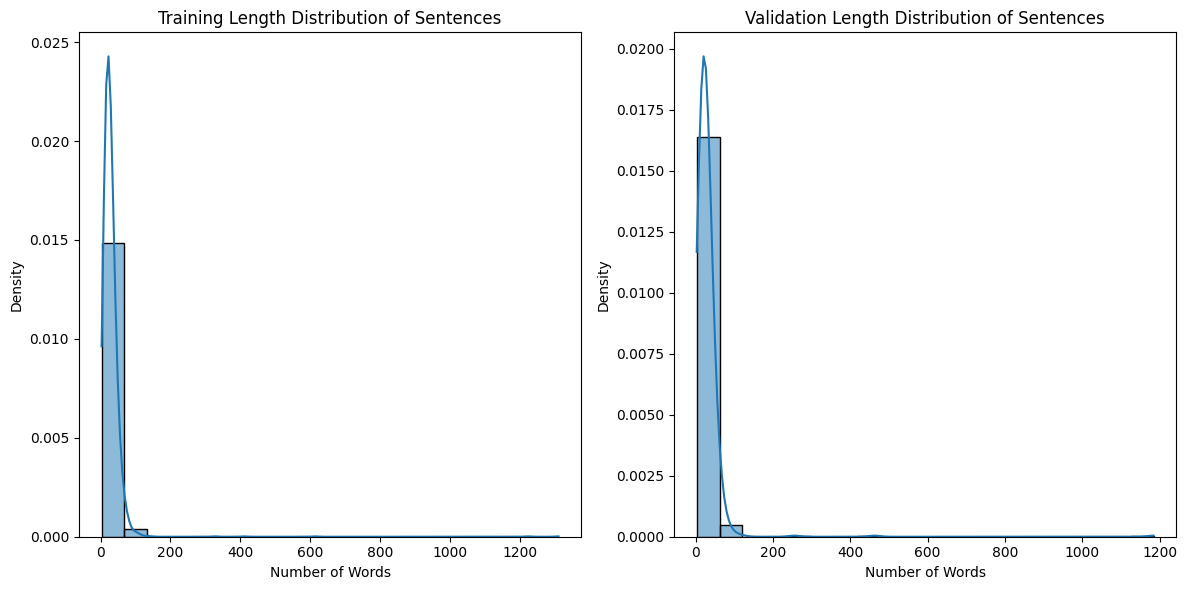

In [6]:
# Length distribution of sentences
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sentence_lengths_train = propaganda_train['tagged_in_context'].apply(lambda x: len(x.split()))
sns.histplot(sentence_lengths_train, bins=20, kde=True, stat='density')
plt.title('Training Length Distribution of Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sentence_lengths_val = propaganda_val['tagged_in_context'].apply(lambda x: len(x.split()))
sns.histplot(sentence_lengths_val, bins=20, kde=True, stat='density')
plt.title('Validation Length Distribution of Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


The histograms illustrate sentence length distributions in word count for the training and validation datasets:

1. **Training Dataset**:
   - Majority of sentences are short, peaking below 50 words.
   - Frequency sharply declines with increasing word count, with few sentences exceeding 200 words.

2. **Validation Dataset**:
   - Similar distribution to training dataset, peaking at low word counts indicating prevalent short sentences.
   - Frequency decreases with higher word counts, mirroring training dataset pattern.

**Key Points**:
- **Consistency**: Both datasets exhibit similar distributions, ensuring alignment in sentence length.
- **Skewness**: Left-skewed distributions suggest a concentration of shorter sentences, potentially impacting model performance.
- **Modeling Considerations**: Adaptations may be needed to handle longer sentence inputs effectively.


In [7]:
def extract_snippet(sentence):
    match = re.search(r'<BOS>(.*?)<EOS>', sentence)
    if match:
        return match.group(1).strip()
    return ""

# Extract snippets and preprocess labels
propaganda_train['snippet'] = propaganda_train['tagged_in_context'].apply(extract_snippet)
propaganda_val['snippet'] = propaganda_val['tagged_in_context'].apply(extract_snippet)

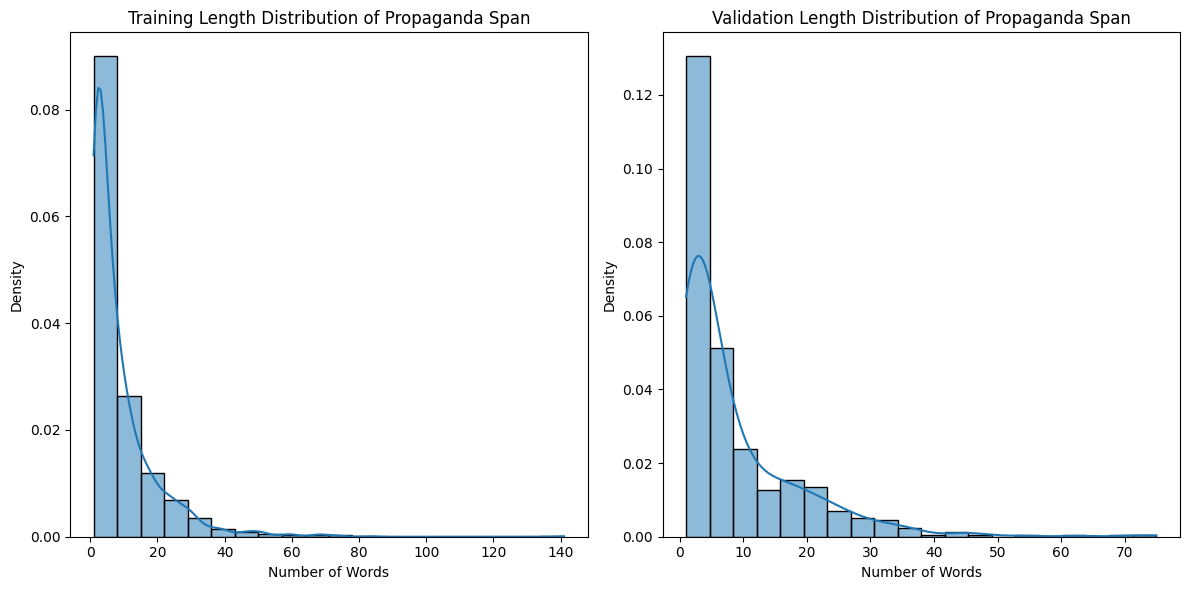

In [8]:
# Length distribution of Propaganda Span
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sentence_lengths_train = propaganda_train['snippet'].apply(lambda x: len(x.split()))
sns.histplot(sentence_lengths_train, bins=20, kde=True, stat='density')
plt.title('Training Length Distribution of Propaganda Span')
plt.xlabel('Number of Words')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sentence_lengths_val = propaganda_val['snippet'].apply(lambda x: len(x.split()))
sns.histplot(sentence_lengths_val, bins=20, kde=True, stat='density')
plt.title('Validation Length Distribution of Propaganda Span')
plt.xlabel('Number of Words')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [9]:
# Sample sentences from each class
print("Sample Sentences:")
label_count = 1  # Initialize a counter for the labels
for label in propaganda_train['label'].unique():
    sample_train = propaganda_train[propaganda_train['label'] == label]['tagged_in_context'].sample(1).values[0]
    print(f"\n{label_count}. '{label}': {sample_train}")

    label_count += 1  # Increment the label counter after each loop iteration


Sample Sentences:

1. 'not_propaganda': <BOS> Shifting the burden of proof to the gun <EOS> owner. 

2. 'flag_waving': <BOS> For me, U.S. aid should be leverage. I will be using my position in Congress so that no country, not one, should be able to get aid from the U.S. when they still promote that kind of injustice <EOS>.” 

3. 'loaded_language': President Donald Trump on Monday ordered Pompeo to rush to the desert kingdom to try to determine the fate of the missing journalist, Jamal Khashoggi, and the diplomat quickly <BOS> hopped <EOS> a plane. 

4. 'doubt': Meanwhile, the local law enforcement investigative services are telling us there is no terrorist connection–lone gunman, again, <BOS> something is not adding up,” <EOS> Perry replied. 

5. 'name_calling,labeling': The likeliest interpretation of his statement is that he is saying that we must not speak about how <BOS> jihadis <EOS> find justification for their actions in the Qur’an and Sunnah, as that will alienate the “moderate

## 3. Task 1: Propaganda Detection



### Baseline Task: TF-IDF with SVM

Establishing a baseline for propaganda detection using TF-IDF with SVM to serve as a reference point for evaluating more complex models in subsequent sections. TF-IDF assigns importance scores to words based on how often they appear in a sentence and how rare they are across all sentences. We then use an SVM classifier, which learns to distinguish between propaganda and non-propaganda sentences.
  
- **Implementation Steps**:
  - Clean and prepare the training data.
  - Vectorize the text data using TF-IDF.
  - Perform hyperparameter tuning for SVM regularization parameter (C) using grid search cross-validation.
  - Train an SVM classifier on the TF-IDF vectors.
  - Evaluate the model on the validation set and report baseline performance metrics (accuracy, precision, recall, F1-score).

In [10]:
def preprocess_text(text, remove_tags=True):
    if remove_tags:
        # Directly remove <BOS> and <EOS> tags
        text = text.replace('<BOS>', '').replace('<EOS>', '')
    else:
        # When not removing, replace with placeholders that are unlikely to be altered
        text = text.replace('<BOS>', 'BOSPLACEHOLDER').replace('<EOS>', 'EOSPLACEHOLDER')

    # Convert text to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove punctuation and special characters, keeping placeholders intact
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Replace placeholders back to original tags if not removed
    if not remove_tags:
        tokens = ['<BOS>' if token == 'bosplaceholder' else token for token in tokens]
        tokens = ['<EOS>' if token == 'eosplaceholder' else token for token in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [11]:
propaganda_train['binary_label'] = np.where(propaganda_train['label'] != 'not_propaganda', 'propaganda', propaganda_train['label'])
propaganda_val['binary_label'] = np.where(propaganda_val['label'] != 'not_propaganda', 'propaganda', propaganda_val['label'])

In [12]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Clean and preprocess the training data
propaganda_train['cleaned_text_tfidf'] = propaganda_train['tagged_in_context'].apply(preprocess_text)

# Clean and preprocess the validation data
propaganda_val['cleaned_text_tfidf'] = propaganda_val['tagged_in_context'].apply(preprocess_text)

# Convert the cleaned training data into TF-IDF vectors
X_train = tfidf_vectorizer.fit_transform(propaganda_train['cleaned_text_tfidf'])
y_binary_train = propaganda_train['binary_label']

# Convert the cleaned validation data into TF-IDF vectors
X_valid = tfidf_vectorizer.transform(propaganda_val['cleaned_text_tfidf'])
y_binary_valid = propaganda_val['binary_label']


In [13]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

In [14]:
# Define the parameter grid for C
param_grid = {'C': [0.1, 1, 10, 100]}

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='accuracy')

# Perform grid search cross-validation on the training data
grid_search.fit(X_train, y_binary_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a new SVM classifier with the best hyperparameters
best_svm_classifier = SVC(kernel='linear', C=best_params['C'])
best_svm_classifier.fit(X_train, y_binary_train)

# Predict labels for validation data using the best classifier
y_pred_best = best_svm_classifier.predict(X_valid)

# Evaluate the best classifier
print("Best SVM Classifier - Classification Report:")
print(classification_report(y_binary_valid, y_pred_best))
print("Best Hyperparameters:", best_params)


Best SVM Classifier - Classification Report:
                precision    recall  f1-score   support

not_propaganda       0.70      0.65      0.68       301
    propaganda       0.65      0.70      0.68       279

      accuracy                           0.68       580
     macro avg       0.68      0.68      0.68       580
  weighted avg       0.68      0.68      0.68       580

Best Hyperparameters: {'C': 1}


In [15]:
# Save the model
import joblib
joblib.dump(best_svm_classifier, '../models/tfidf_svm_model.pkl')

# Save results
results = pd.DataFrame(classification_report(y_binary_valid, y_pred_best, output_dict=True))
results.to_csv('../results/tfidf_svm_results.csv')

### Word2Vec with SVM
- Train Word2Vec embeddings on the training data.
- Convert each sentence into a fixed-length vector representation using Word2Vec embeddings (e.g., averaging word vectors).
    - Give weight to the detected propaganda span
    - Get the word2vec vector representation for each word in the sentence using the gensim library
    - Take the average of the vector representation of all words in the sentence
- Perform hyperparameter tuning for SVM regularization parameter (C) using grid search cross-validation.
- Train an SVM classifier on the Word2Vec vectors.
- Evaluate the model on the validation dataset and report performance metrics.

Prepare the data

In [16]:
# Load the spaCy model
nlp = spacy.load("en_core_web_md")

In [17]:
def wtv_preprocess_text(text, weight=3):
    words = text.split()
    new_words = []
    in_span = False

    for word in words:
        if word == '<BOS>':
            in_span = True
            continue
        elif word == '<EOS>':
            in_span = False
            continue

        if in_span:
            # Repeat the word `weight` times if it's within the span
            new_words.extend([word] * weight)
        else:
            new_words.append(word)
    
    return ' '.join(new_words)



In [ ]:
def sentence_to_vector(sentence, nlp_model):
    doc = nlp_model(sentence)
    if doc.vector_norm:
        return doc.vector
    else:
        return np.zeros(nlp_model.vocab.vectors_length)

In [18]:
wtv_train_texts = [wtv_preprocess_text(text) for text in propaganda_train['tagged_in_context'].apply(preprocess_text, remove_tags=False)]
wtv_val_texts = [wtv_preprocess_text(text) for text in propaganda_val['tagged_in_context'].apply(preprocess_text, remove_tags=False)]

In [ ]:
# Train Word2Vec model using skip-gram (sg=1) on the training texts, with a vector size of 300, a context window of 15, and including all words that appear at least once
word2vec_model = Word2Vec(sentences=[sentence.split() for sentence in wtv_train_texts], vector_size=300, window=15, min_count=1, workers=4, sg=1)


In [ ]:
def sentence_to_vector(sentence, word2vec_model):
    tokens = sentence.split()
    vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)



In [ ]:
# Convert sentences to Word2Vec vectors
label_encoder = LabelEncoder()
y_train_word2vec = label_encoder.fit_transform(y_binary_train)
y_valid_word2vec = label_encoder.fit_transform(y_binary_valid)

X_train_word2vec = np.array([sentence_to_vector(sentence, word2vec_model) for sentence in wtv_train_texts])
X_valid_word2vec = np.array([sentence_to_vector(sentence, word2vec_model) for sentence in wtv_val_texts])

# Perform hyperparameter tuning for SVM regularization parameter (C) using grid search cross-validation
param_grid = {'C': [1, 10, 15, 10, 20, 30]}
svm_classifier = SVC(kernel='rbf', gamma='scale')
grid_search = GridSearchCV(svm_classifier, param_grid, cv=cv_strategy, scoring='accuracy')
grid_search.fit(X_train_word2vec, y_train_word2vec)
best_params = grid_search.best_params_

# Train SVM classifier on Word2Vec vectors
svm_classifier = SVC(kernel='rbf', gamma='scale', C=best_params['C'])
svm_classifier.fit(X_train_word2vec, y_train_word2vec)


# Evaluate the SVM classifier on the validation set
y_pred_word2vec = svm_classifier.predict(X_valid_word2vec)
print("Word2Vec with SVM - Classification Report:")
print(classification_report(y_valid_word2vec, y_pred_word2vec, target_names=label_encoder.classes_))
print("Best hyperparameters:", best_params)


In [ ]:
# Save the model
joblib.dump(svm_classifier, '../models/word2vec_svm_model.pkl')

# Save results
results = pd.DataFrame(classification_report(y_valid_word2vec, y_pred_word2vec, target_names=label_encoder.classes_, output_dict=True))
results.to_csv('../results/word2vec_svm_model.csv')

### BERT Sequence Classification
- Fine-tune a pre-trained BERT model for sequence classification on the task.
- Tokenize the sentences and prepare them for input to BERT.
- Perform hyperparameter tuning for BERT fine-tuning parameters (learning rate, batch size, etc.).
- Train the BERT model on the training data.
- Evaluate the model on the test set.
- Report performance metrics.

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        try:
            item = {key: self.encodings[key][idx] for key in self.encodings}
            item['labels'] = self.labels[idx]
            return item
        except IndexError as e:
            print(f'Error at index: {idx}')
            raise e

    def __len__(self):
        return len(self.labels)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def train_bert(model_name, num_labels, train_labels, val_labels, epochs=3, batch_size=8):

    bert_config = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Load a cased BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained(model_name)

    # Add special tokens
    special_tokens_dict = {'additional_special_tokens': ['<BOS>', '<EOS>']}
    bert_tokenizer.add_special_tokens(special_tokens_dict)

    # Resize bert_multi_model embeddings to account for new tokens
    bert_config.resize_token_embeddings(len(bert_tokenizer))

    def prepare_bert_data(train_texts, val_texts, train_labels, val_labels, tokenizer=bert_tokenizer):
        # Tokenize the training and validation data
        train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
        val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
        
        # Initialize label encoder based on the type of classification
        label_encoder = LabelEncoder()
        train_labels = label_encoder.fit_transform(train_labels)
        val_labels = label_encoder.transform(val_labels)

        # Return a dictionary containing all the processed data
        return {
            'train_encodings': train_encodings,
            'val_encodings': val_encodings,
            'train_labels': train_labels,
            'val_labels': val_labels
        }


    prepared_bert_data = prepare_bert_data(list(propaganda_train['tagged_in_context']), list(propaganda_val['tagged_in_context']), list(train_labels), list(val_labels))

    train_dataset = PropagandaDataset(prepared_bert_data['train_encodings'], prepared_bert_data['train_labels'])
    val_dataset = PropagandaDataset(prepared_bert_data['val_encodings'], prepared_bert_data['val_labels'])

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        save_strategy="epoch",
        evaluation_strategy="epoch"
    )

    # Update Trainer setup
    trainer = Trainer(
        model=bert_config,
        args=training_args,
        train_dataset=train_dataset,  
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    return bert_config, trainer



In [ ]:
bert_config, binary_class_bert = train_bert('bert-base-cased', 2, y_binary_train, y_binary_valid, epochs=3, batch_size=8)

In [ ]:
# Save the trained model and tokenizer
model_save_path = '../models/bert_binary_class_model'
binary_class_bert.save_model(model_save_path)

# Evaluate the model
eval_result = binary_class_bert.evaluate()

import json
# Save evaluation results to a file
eval_result_file = '../results/bert_binary_results.json'
with open(eval_result_file, 'w') as f:
    json.dump(eval_result, f)

## 4. Task 2: Propaganda Type Detection



### Baseline Task: TF-IDF with SVM
- Vectorize the text data using TF-IDF.
- Perform hyperparameter tuning for SVM regularization parameter (C) using grid search cross-validation.
- Train an SVM classifier on the TF-IDF vectors.
- Evaluate the model on the test set.
- Report baseline performance metrics (accuracy, precision, recall, F1-score).

In [ ]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Clean and preprocess the training data
propaganda_train['cleaned_text_tfidf'] = propaganda_train['tagged_in_context'].apply(preprocess_text)

# Clean and preprocess the validation data
propaganda_val['cleaned_text_tfidf'] = propaganda_val['tagged_in_context'].apply(preprocess_text)

# Convert the cleaned training data into TF-IDF vectors
X_train = tfidf_vectorizer.fit_transform(propaganda_train['cleaned_text_tfidf'])
y_multi_train = propaganda_train['label']

# Convert the cleaned validation data into TF-IDF vectors
X_valid = tfidf_vectorizer.transform(propaganda_val['cleaned_text_tfidf'])
y_multi_valid = propaganda_val['label']


In [ ]:
smote = SMOTE(random_state=42)
train_vectors_resampled, multi_train_labels_resampled = smote.fit_resample(X_train, y_multi_train)

In [ ]:
# Define the parameter grid for C
param_grid = {'C': [0.1, 1, 10, 20, 50, 100]}

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=cv_strategy, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform grid search cross-validation on the resampled training data
grid_search.fit(train_vectors_resampled, multi_train_labels_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a new SVM classifier with the best hyperparameters
best_svm_classifier = SVC(kernel='linear', C=best_params['C'])
best_svm_classifier.fit(train_vectors_resampled, multi_train_labels_resampled)

# Predict labels for validation data using the best classifier
y_pred_best = best_svm_classifier.predict(X_valid)

# Evaluate the best classifier
print("Best SVM Classifier - Classification Report:")
print(classification_report(y_multi_valid, y_pred_best))
print("Best Hyperparameters:", best_params)


In [ ]:
# Save the model
import joblib
joblib.dump(best_svm_classifier, '../models/tfidf_svm_multi_model.pkl')

# Save results
results = pd.DataFrame(classification_report(y_multi_valid, y_pred_best, output_dict=True))
results.to_csv('../results/tfidf_svm_multi_results.csv')

### Word2Vec with SVM
- Train Word2Vec embeddings on the training data.
- Convert each sentence into a fixed-length vector representation using Word2Vec embeddings (e.g., averaging word vectors).
- Perform hyperparameter tuning for SVM regularization parameter (C) using grid search cross-validation.
- Train an SVM classifier on the Word2Vec vectors.
- Evaluate the model on the validation dataset and report performance metrics.

We'll be considering how well our trained word2vec model can predict the propaganda types

In [ ]:
# encode the multi-class labels
y_train_word2vec = label_encoder.fit_transform(y_multi_train)
y_valid_word2vec = label_encoder.fit_transform(y_multi_valid)

# Resample the Word2Vec training vectors using SMOTE
X_train_word2vec_resampled, y_train_word2vec_resampled = smote.fit_resample(X_train_word2vec, y_train_word2vec)


In [ ]:

# Perform hyperparameter tuning for SVM regularization parameter (C) using grid search cross-validation
param_grid = {'C': [0.1, 1, 10, 20, 30, 50, 100, 150]}
svm_classifier = SVC(kernel='rbf', gamma='scale')
grid_search = GridSearchCV(svm_classifier, param_grid, cv=cv_strategy, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_word2vec_resampled, y_train_word2vec_resampled)
best_params = grid_search.best_params_

# Train SVM classifier on Word2Vec vectors
svm_classifier = SVC(kernel='rbf', gamma='scale', C=best_params['C'])
svm_classifier.fit(X_train_word2vec_resampled, y_train_word2vec_resampled)

# Evaluate the SVM classifier on the validation set
y_pred_word2vec = svm_classifier.predict(X_valid_word2vec)
print("Word2Vec with SVM - Multi Classification Report:")
print(classification_report(y_valid_word2vec, y_pred_word2vec, target_names=label_encoder.classes_))
print("Best hyperparameters:", best_params)


In [ ]:
# Save the model
joblib.dump(svm_classifier, '../models/word2vec_svm_multi_model.pkl')

# Save results
results = pd.DataFrame(classification_report(y_valid_word2vec, y_pred_word2vec, target_names=label_encoder.classes_, output_dict=True))
results.to_csv('../results/word2vec_svm_multi_model.csv')

### BERT Sequence Classification
- Fine-tune a pre-trained BERT model for sequence classification on the task.
- Tokenize the sentences and prepare them for input to BERT.
- Perform hyperparameter tuning for BERT fine-tuning parameters (learning rate, batch size, etc.).
- Train the BERT model on the training data.
- Evaluate the model on the test set.
- Report performance metrics.

In [ ]:
y_multi_valid

In [ ]:
bert_config, multi_class_bert_5 = train_bert('bert-base-cased', 9, y_multi_train, y_multi_valid, epochs=5, batch_size=8)

In [ ]:
model_save_path = '../models/bert_multi_class_model'
multi_class_bert_5.save_model(model_save_path)

# Evaluate the model
eval_result = multi_class_bert_5.evaluate()

import json
# Save evaluation results to a file
eval_result_file = '../results/bert_multi_results.json'
with open(eval_result_file, 'w') as f:
    json.dump(eval_result, f)